In [1]:
# 03_model_nn.ipynb
# Simple neural network model on the processed UCI diabetes cohort

import sys
import os

repo_root = os.path.abspath("..")
if repo_root not in sys.path:
    sys.path.append(repo_root)

print("Repo root:", repo_root)

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt

from src.train import split_data

PROCESSED_PATH = "../data_processed/admissions_features.csv"

df = pd.read_csv(PROCESSED_PATH)
print("Raw processed shape:", df.shape)
df.head()

Repo root: /Users/vathsan/idle-workspace/COMPSCI184A/med-sideeffect-risk
Raw processed shape: (101763, 25)


,encounter_id,patient_nbr,age_num,sex_female,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,...,comorb_obese,insulin_use,oral_med_count,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_Unknown,label
0,2278392,8222157,5,1,1,41,0,1,0,0,...,0,0,0,False,False,True,False,False,False,0
1,149190,55629189,15,1,3,59,0,18,0,0,...,0,1,0,False,False,True,False,False,False,0
2,64410,86047875,25,1,2,11,5,13,2,0,...,0,0,1,True,False,False,False,False,False,0
3,500364,82442376,35,0,2,44,1,16,0,0,...,0,1,0,False,False,True,False,False,False,0
4,16680,42519267,45,0,1,51,0,8,0,0,...,0,1,1,False,False,True,False,False,False,0


In [2]:
label_col = "label"
id_cols = ["encounter_id", "patient_nbr"]

# use same splitting function as in 02
X_train, X_val, X_test, y_train, y_val, y_test = split_data(df, label_col=label_col)

# drop ID + label columns from features
drop_cols = id_cols + [label_col]
X_train = X_train.drop(columns=[c for c in drop_cols if c in X_train.columns])
X_val   = X_val.drop(columns=[c for c in drop_cols if c in X_val.columns])
X_test  = X_test.drop(columns=[c for c in drop_cols if c in X_test.columns])

print("X_train:", X_train.shape)
print("X_val:",   X_val.shape)
print("X_test:",  X_test.shape)

y_train = y_train.values
y_val   = y_val.values
y_test  = y_test.values

print("Positive rate (train):", y_train.mean())

X_train: (71234, 22)
X_val: (15264, 22)
X_test: (15265, 22)
Positive rate (train): 0.11160400932139147


In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape

((71234, 22), (15264, 22), (15265, 22))

In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_t   = torch.tensor(X_val_scaled,   dtype=torch.float32)
X_test_t  = torch.tensor(X_test_scaled,  dtype=torch.float32)

y_train_t = torch.tensor(y_train, dtype=torch.float32)
y_val_t   = torch.tensor(y_val,   dtype=torch.float32)
y_test_t  = torch.tensor(y_test,  dtype=torch.float32)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t,   y_val_t)
test_ds  = TensorDataset(X_test_t,  y_test_t)

batch_size = 256

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

Using device: cpu


In [5]:
import torch.nn as nn
import torch.nn.functional as F
from src.models_nn import TabularNN

input_dim = X_train_t.shape[1]
print("Input dim:", input_dim)

model = TabularNN(input_dim).to(device)
model

Input dim: 22


TabularNN(
  (net): Sequential(
    (0): Linear(in_features=22, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [6]:
# compute pos_weight = (#neg / #pos) for train set
pos = y_train.sum()
neg = len(y_train) - pos
pos_weight_value = neg / max(pos, 1)

pos_weight = torch.tensor([pos_weight_value], dtype=torch.float32, device=device)
print("pos_weight:", pos_weight.item())

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-4,   # L2 regularization
)

pos_weight: 7.960251808166504


In [7]:
def evaluate_nn(model, data_loader):
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for xb, yb in data_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            probs = torch.sigmoid(logits)
            all_probs.append(probs.cpu().numpy())
            all_labels.append(yb.cpu().numpy())
    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)
    auroc = roc_auc_score(all_labels, all_probs)
    auprc = average_precision_score(all_labels, all_probs)
    return auroc, auprc, all_probs, all_labels

num_epochs = 200
best_val_auroc = 0.0
best_state = None

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)

    train_loss = running_loss / len(train_loader.dataset)

    # validation metrics
    val_auroc, val_auprc, _, _ = evaluate_nn(model, val_loader)

    if val_auroc > best_val_auroc:
        best_val_auroc = val_auroc
        best_state = model.state_dict()

    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | "
          f"val_AUROC={val_auroc:.4f} | val_AUPRC={val_auprc:.4f}")

# load best model (by val AUROC)
if best_state is not None:
    model.load_state_dict(best_state)
    print("Loaded best model with val AUROC:", best_val_auroc)

Epoch 01 | train_loss=1.1922 | val_AUROC=0.6292 | val_AUPRC=0.1969
Epoch 02 | train_loss=1.1827 | val_AUROC=0.6340 | val_AUPRC=0.1987
Epoch 03 | train_loss=1.1799 | val_AUROC=0.6338 | val_AUPRC=0.1991
Epoch 04 | train_loss=1.1776 | val_AUROC=0.6337 | val_AUPRC=0.1987
Epoch 05 | train_loss=1.1768 | val_AUROC=0.6353 | val_AUPRC=0.1998
Epoch 06 | train_loss=1.1756 | val_AUROC=0.6351 | val_AUPRC=0.1994
Epoch 07 | train_loss=1.1744 | val_AUROC=0.6343 | val_AUPRC=0.1989
Epoch 08 | train_loss=1.1734 | val_AUROC=0.6352 | val_AUPRC=0.1990
Epoch 09 | train_loss=1.1734 | val_AUROC=0.6332 | val_AUPRC=0.1982
Epoch 10 | train_loss=1.1732 | val_AUROC=0.6349 | val_AUPRC=0.2001
Epoch 11 | train_loss=1.1717 | val_AUROC=0.6341 | val_AUPRC=0.1999
Epoch 12 | train_loss=1.1720 | val_AUROC=0.6337 | val_AUPRC=0.1979
Epoch 13 | train_loss=1.1708 | val_AUROC=0.6340 | val_AUPRC=0.1987
Epoch 14 | train_loss=1.1694 | val_AUROC=0.6316 | val_AUPRC=0.1980
Epoch 15 | train_loss=1.1696 | val_AUROC=0.6334 | val_AUPRC=0.

In [8]:
test_auroc, test_auprc, test_probs, test_labels = evaluate_nn(model, test_loader)

print("Final NN performance on TEST set:")
print(f"AUROC: {test_auroc:.4f}")
print(f"AUPRC: {test_auprc:.44f}")

Final NN performance on TEST set:
AUROC: 0.6284
AUPRC: 0.18646073560173154204377965470484923571348190


Accuracy: 0.6510972813625941
Confusion matrix:
 [[9087 4474]
 [ 852  852]]


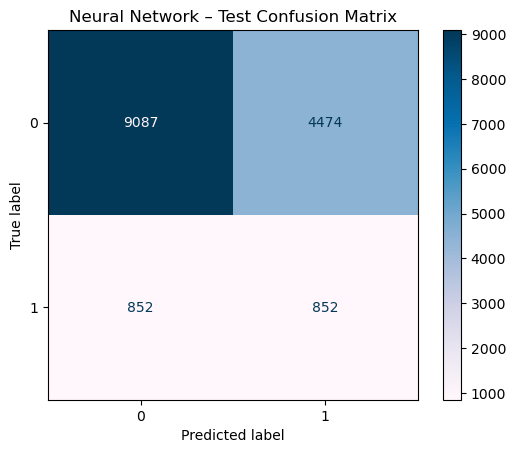

Classification report:
               precision    recall  f1-score   support

         0.0      0.914     0.670     0.773     13561
         1.0      0.160     0.500     0.242      1704

    accuracy                          0.651     15265
   macro avg      0.537     0.585     0.508     15265
weighted avg      0.830     0.651     0.714     15265



In [9]:
test_preds = (test_probs >= 0.5).astype(int)
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

acc = accuracy_score(test_labels, test_preds)
cm = confusion_matrix(test_labels, test_preds)
print("Accuracy:", acc)
print("Confusion matrix:\n", cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(values_format="d", cmap="PuBu")
plt.title("Neural Network – Test Confusion Matrix")
plt.show()
print("Classification report:\n", classification_report(test_labels, test_preds, digits=3))

In [10]:
def get_embeddings(model, data_loader, device):
    model.eval()
    all_emb = []
    all_labels = []
    with torch.no_grad():
        for xb, yb in data_loader:
            xb = xb.to(device)
            # pass through all layers except the final linear output layer
            h = model.net[:-1](xb)
            all_emb.append(h.cpu().numpy())
            all_labels.append(yb.numpy())
    return np.concatenate(all_emb, axis=0), np.concatenate(all_labels, axis=0)

X_train_emb, y_train_emb = get_embeddings(model, train_loader, device)
X_val_emb,   y_val_emb   = get_embeddings(model, val_loader, device)
X_test_emb,  y_test_emb  = get_embeddings(model, test_loader, device)

np.save("../data_processed/X_train_emb.npy", X_train_emb)
np.save("../data_processed/X_val_emb.npy",   X_val_emb)
np.save("../data_processed/X_test_emb.npy",  X_test_emb)
np.save("../data_processed/y_train_emb.npy", y_train_emb)
np.save("../data_processed/y_val_emb.npy",   y_val_emb)
np.save("../data_processed/y_test_emb.npy",  y_test_emb)